In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow import keras
from tensorflow.keras import layers
from keras.metrics import Recall, Precision
import matplotlib.pyplot as plt
import hashlib

2024-07-13 17:47:12.915293: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-13 17:47:12.972983: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 17:47:12.973025: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 17:47:12.973068: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-13 17:47:12.984490: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-13 17:47:12.985590: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
df = pd.read_parquet('/home/administrator/dataset/NF-UQ-NIDS/NF-UQ-NIDS-V2.parquet', engine='pyarrow')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62672013 entries, 0 to 62672012
Data columns (total 44 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   L4_SRC_PORT                  int16  
 1   L4_DST_PORT                  int16  
 2   PROTOCOL                     int16  
 3   L7_PROTO                     float32
 4   IN_BYTES                     int32  
 5   IN_PKTS                      int32  
 6   OUT_BYTES                    int32  
 7   OUT_PKTS                     int32  
 8   TCP_FLAGS                    int16  
 9   CLIENT_TCP_FLAGS             int16  
 10  SERVER_TCP_FLAGS             int16  
 11  FLOW_DURATION_MILLISECONDS   int32  
 12  DURATION_IN                  int32  
 13  DURATION_OUT                 int32  
 14  MIN_TTL                      int16  
 15  MAX_TTL                      int16  
 16  LONGEST_FLOW_PKT             int32  
 17  SHORTEST_FLOW_PKT            int16  
 18  MIN_IP_PKT_LEN               int16  
 19

In [4]:
df = df.drop(df.columns[[42, 43]], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62672013 entries, 0 to 62672012
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   L4_SRC_PORT                  int16  
 1   L4_DST_PORT                  int16  
 2   PROTOCOL                     int16  
 3   L7_PROTO                     float32
 4   IN_BYTES                     int32  
 5   IN_PKTS                      int32  
 6   OUT_BYTES                    int32  
 7   OUT_PKTS                     int32  
 8   TCP_FLAGS                    int16  
 9   CLIENT_TCP_FLAGS             int16  
 10  SERVER_TCP_FLAGS             int16  
 11  FLOW_DURATION_MILLISECONDS   int32  
 12  DURATION_IN                  int32  
 13  DURATION_OUT                 int32  
 14  MIN_TTL                      int16  
 15  MAX_TTL                      int16  
 16  LONGEST_FLOW_PKT             int32  
 17  SHORTEST_FLOW_PKT            int16  
 18  MIN_IP_PKT_LEN               int16  
 19

In [5]:
df['Label'].value_counts()

Label
1    41928190
0    20743823
Name: count, dtype: int64

In [6]:
X_df = df.drop(columns=['Label'])
y_df = df['Label']

In [7]:
scaler = QuantileTransformer(output_distribution='normal')

In [8]:
X_df_scl = scaler.fit_transform(X_df)

In [9]:
def load_NFUQ_data(client_id):
    
    # Create non-IID splits based on client_id
    np.random.seed(client_id)
    indices = np.arange(len(X_df_scl))
    np.random.shuffle(indices)

    # Choose a fraction of the data for this client
    fraction = 0.02
    client_data_size = int(fraction * len(X_df_scl))
    client_indices = indices[:client_data_size]

    X_client = X_df_scl[client_indices]
    y_client = y_df.iloc[client_indices]

    return X_client, y_client

In [10]:
# Define a simple neural network model
def create_model(input_shape):
    model = keras.Sequential([
        layers.Dense(20, activation='relu', input_shape=(input_shape,)),
        layers.Dense(10, activation='relu'),
        layers.Dense(5, activation='relu'),
        layers.Dense(3, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy', Recall(), Precision()])
    return model

In [11]:
# Block structure to store model performance and trust scores
class Block:
    def __init__(self, index, target_accuracy, trust_scores, anomalies_detected, previous_hash):
        self.index = index
        self.target_accuracy = target_accuracy
        self.trust_scores = trust_scores
        self.anomalies_detected = anomalies_detected
        self.previous_hash = previous_hash
        self.hash = self.compute_hash()

    def compute_hash(self):
        sha = hashlib.sha256()
        sha.update(str(self.index).encode('utf-8') +
                   str(self.target_accuracy).encode('utf-8') +
                   str(self.trust_scores).encode('utf-8') +
                   str(self.anomalies_detected).encode('utf-8') +
                   str(self.previous_hash).encode('utf-8'))
        return sha.hexdigest()

# Blockchain structure
class Blockchain:
    def __init__(self):
        self.chain = []

    def create_block(self, target_accuracy, trust_scores, anomalies_detected, previous_hash):
        block = Block(len(self.chain), target_accuracy, trust_scores, anomalies_detected, previous_hash)
        self.chain.append(block)
        print(f"Block {block.index} created with hash: {block.hash}, previous hash: {block.previous_hash}")
        return block

    def get_last_block(self):
        return self.chain[-1]

In [12]:
# Function to simulate false data injection
def inject_false_data(X, Y, corruption_rate=0.1):
    Y = Y.to_numpy()  # Convert Series to NumPy array
    num_corrupt_samples = int(len(Y) * corruption_rate)
    corrupt_indices = np.random.choice(len(Y), num_corrupt_samples, replace=False)
    Y[corrupt_indices] = 1 - Y[corrupt_indices]  # Flip the labels
    return X, pd.Series(Y)  # Convert back to Series if needed

In [13]:
# Specify malicious nodes and rounds
malicious_nodes = [1, 2, 4]
malicious_rounds = [1, 2, 3, 4, 5]

In [14]:
# Federated learning training process with PoAD
def poad_federated_training(num_nodes=5, num_rounds=5, inject_corruption=False, corruption_rate=0.1):
    blockchain = Blockchain()
    input_shape_glob = X_df_scl.shape[1]
    global_model = create_model(input_shape=input_shape_glob)
    global_weights = global_model.get_weights()
    round_accuracies = []
    target_accuracies = []
    global_accuracies = []
    global_precisions = []
    global_recalls = []
    global_f1s = []

    # Round 0: Initial target accuracy determination
    init_weights = []
    all_X_test = []
    all_Y_test = []
    
    # Initialize trust scores
    trust_scores = [1.0] * num_nodes
    
    initial_accuracies = []
    
    for node in range(num_nodes):
        X, Y = load_NFUQ_data(node)
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
        
        all_X_test.append(X_val)
        all_Y_test.append(Y_val)
        
        input_shape = X_train.shape[1]

        model = create_model(input_shape=input_shape)
        model.set_weights(global_weights)
        model.fit(X_train, Y_train, epochs=1, verbose=0)

        # Validation
        loss, accuracy, precision, recall = model.evaluate(X_val, Y_val, verbose=1)
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
        print(f"Node {node + 1}: Initial - Accuracy {accuracy:.4f} - Precision {precision:.4f} - Recall {recall:.4f} - F1-Score {f1_score:.4f}")
        
        init_weights.append(model.get_weights())
        initial_accuracies.append(accuracy)
        
    # Aggregate initial weights
    avg_init_weights = [np.mean([weight[layer] for weight in init_weights], axis=0) for layer in range(len(global_weights))]
    global_weights = avg_init_weights
    global_model.set_weights(global_weights)
    
    # Evaluate initial global model accuracy
    tmp_accuracies = []
    tmp_precisions = []
    tmp_recalls = []
    tmp_f1s = []
    for X_test, Y_test in zip(all_X_test, all_Y_test):
        loss, accuracy, precision, recall = global_model.evaluate(X_test, Y_test, verbose=1)
        tmp_accuracies.append(accuracy)
        tmp_precisions.append(precision)
        tmp_recalls.append(recall)
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
        tmp_f1s.append(f1_score)
        
    init_accuracies = np.mean(tmp_accuracies)
    init_precisions = np.mean(tmp_precisions)
    init_recalls = np.mean(tmp_recalls)
    init_f1s = np.mean(tmp_f1s)
    
    global_accuracies.append(init_accuracies)
    global_precisions.append(init_precisions)
    global_recalls.append(init_recalls)
    global_f1s.append(init_f1s)
    
    print(f"\nRound 0: Initial - Accuracy {init_accuracies:.4f} - Precision {init_precisions:.4f} - Recall {init_recalls:.4f} - F1-Score {init_f1s:.4f}")
    
    target_accuracy = init_accuracies
    print(f"Round 0: Initial target accuracy set to {target_accuracy:.4f}\n")
    target_accuracies.append(target_accuracy)
    round_accuracies.append(init_accuracies)

    # Save the initial block in the blockchain
    blockchain.create_block(target_accuracy=target_accuracy, trust_scores=trust_scores, anomalies_detected=[False]*num_nodes, previous_hash='0')
    
    X_test_round, Y_test_round = load_NFUQ_data(7)

    # Subsequent rounds
    for round in range(1, num_rounds + 1):
        local_weights = []
        local_accuracies = []
        nodes_data = []
        
        for node in range(num_nodes):
            X, y = load_NFUQ_data(node)
            
            # Label flipping for malicious nodes
            if node in malicious_nodes and inject_corruption:
                X, y = inject_false_data(X, Y, corruption_rate)
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
            nodes_data.append((X_train, X_test, y_train, y_test))
            
        node_validities = []

        for node in range(num_nodes):
            X_train, X_val, Y_train, Y_val = nodes_data[node]
            
            input_shape = X_train.shape[1]

            model = create_model(input_shape=input_shape)
            model.set_weights(global_weights)
            model.fit(X_train, Y_train, epochs=1, verbose=0)
            
            # Check validity based on other nodes' data including local test data
            accuracies = []
            for other_node in range(num_nodes):
                _, X_other_test, _, y_other_test = nodes_data[other_node]
                loss, accuracy, precision, recall = model.evaluate(X_other_test, y_other_test, verbose=1)
                print(f"Node {node+1} model tested on Node {other_node+1} data - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
                accuracies.append(accuracy)

            # Determine the highest accuracy among all nodes' test results
            highest_accuracy = max(accuracies)

            # A model is valid if its accuracy is not significantly below the highest accuracy
            is_valid = all(accuracy >= highest_accuracy * 0.9 for accuracy in accuracies)
            node_validities.append(is_valid)

            if is_valid:
                local_weights.append(model.get_weights())
                local_accuracies.append(np.mean(accuracies))

        # Check if the majority of local models meet the target accuracy across nodes
        if sum(node_validities) > num_nodes // 2:
            # Aggregate weights
            new_weights = [np.mean([weight[layer] for weight in local_weights], axis=0) for layer in range(len(global_weights))]
            global_weights = new_weights
            valid_accuracies = [acc for i, acc in enumerate(local_accuracies) if node_validities[i]]
            new_target_accuracy = np.mean(valid_accuracies)
            if new_target_accuracy > target_accuracy:
                target_accuracy = new_target_accuracy
            print(f"Round {round}: Aggregated weights, new target accuracy: {target_accuracy:.4f}\n")
        else:
            print(f"Round {round}: Insufficient accurate models, retaining previous global model.\n")

        round_accuracies.append(local_accuracies)
        target_accuracies.append(target_accuracy)
        global_model.set_weights(global_weights)
        
        # Update trust scores based on node validities
        for node in range(num_nodes):
            if node_validities[node]:
                trust_scores[node] += 0.1
            else:
                trust_scores[node] -= 0.3

            # Apply decay to trust scores
            trust_scores[node] = max(0, trust_scores[node] * 0.99)
            
        # Detect anomalies based on trust scores
        anomalies_detected = [score < 0.5 for score in trust_scores]

        # Save the aggregated model in a new block after training
        last_block_hash = blockchain.get_last_block().hash
        blockchain.create_block(target_accuracy=target_accuracy, trust_scores=trust_scores, anomalies_detected=anomalies_detected, previous_hash=last_block_hash)

        # Evaluate global model accuracy
        loss, accuracy, precision, recall = global_model.evaluate(X_test_round, Y_test_round, verbose=1)
        global_accuracies.append(accuracy)
        global_precisions.append(precision)
        global_recalls.append(recall)
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
        global_f1s.append(f1_score)
        
        print(f"\nRound {round}: Accuracy {accuracy:.4f} - Precision {precision:.4f} - Recall {recall:.4f} - F1-Score {f1_score:.4f}\n")
    
    # Detect malicious nodes based on reputation scores
    threshold_trust = 0.5  # Set a threshold for reputation
    malicious_detected = [node for node, score in enumerate(trust_scores) if score < threshold_trust]

    print("Detected malicious nodes based on reputation scores:")
    print(malicious_detected)
    
    # Display blockchain information
    for block in blockchain.chain:
        print(f"Block {block.index} - Hash: {block.hash}, Previous Hash: {block.previous_hash}")
        print(f"Target Accuracy: {block.target_accuracy}")
        print(f"Trust Scores: {block.trust_scores}")
        print(f"Anomalies Detected: {block.anomalies_detected}")
        print("")
    
    return global_model, round_accuracies, target_accuracies, global_accuracies, global_precisions, global_recalls, global_f1s, blockchain

In [15]:
# Traditional federated learning training process
def traditional_federated_training(num_nodes=5, num_rounds=5, inject_corruption=False, corruption_rate=0.1):
    input_shape_glob = X_df_scl.shape[1]
    global_model = create_model(input_shape=input_shape_glob)
    global_weights = global_model.get_weights()
    round_accuracies = []
    global_accuracies = []
    global_precisions = []
    global_recalls = []
    global_f1s = []

    # Initial evaluation
    X_test, Y_test = load_NFUQ_data(7)

    # Training rounds
    for round in range(num_rounds + 1):
        local_weights = []
        local_accuracies = []

        for node in range(num_nodes):
            X, Y = load_NFUQ_data(node)
            
            # Label flipping for malicious nodes
            if node in malicious_nodes and round in malicious_rounds and inject_corruption:
                X, Y = inject_false_data(X, Y, corruption_rate)
                    
            X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
            
            input_shape = X_train.shape[1]

            model = create_model(input_shape=input_shape)
            model.set_weights(global_weights)
            model.fit(X_train, Y_train, epochs=1, verbose=0)

            # Validation
            loss, accuracy, precision, recall = model.evaluate(X_val, Y_val, verbose=1)
            f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
            print(f"Node {node + 1}: Accuracy {accuracy:.4f} - Precision {precision:.4f} - Recall {recall:.4f} - F1-Score {f1_score:.4f}")

            local_weights.append(model.get_weights())
            local_accuracies.append(accuracy)

        # Aggregate weights
        new_weights = [np.mean([weight[layer] for weight in local_weights], axis=0) for layer in range(len(global_weights))]
        global_weights = new_weights

        round_accuracies.append(local_accuracies)
        global_model.set_weights(global_weights)

        # Evaluate global model accuracy
        loss, accuracy, precision, recall = model.evaluate(X_test, Y_test, verbose=1)
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
        global_accuracies.append(accuracy)
        global_precisions.append(precision)
        global_recalls.append(recall)
        global_f1s.append(f1_score)
        
        print(f"\nRound {round}: Accuracy {accuracy:.4f} - Precision {precision:.4f} - Recall {recall:.4f} - F1-Score {f1_score:.4f}\n")

    return global_model, round_accuracies, global_accuracies, global_precisions, global_recalls, global_f1s

In [16]:
# Comparison function for traditional FL and PoAD under normal and threat conditions
X_glob_test, Y_glob_test = load_NFUQ_data(10)

In [17]:
# Traditional FL under normal conditions
print("Traditional FL - Normal Conditions\n")
fl_model_normal, fl_round_accuracies_normal, fl_global_accuracies_normal, fl_global_precisions_normal, fl_global_recalls_normal, fl_global_f1s_normal = traditional_federated_training()

loss1, accuracy1, precision1, recall1 = fl_model_normal.evaluate(X_glob_test, Y_glob_test, verbose=1)
f1_score1 = 2 * (precision1 * recall1) / (precision1 + recall1 + 1e-10)
print(f"\nGlobal Test FL Normal: Accuracy {accuracy1:.4f} - Precision {precision1:.4f} - Recall {recall1:.4f} - F1-Score {f1_score1:.4f}\n")

Traditional FL - Normal Conditions

7834/7834 [==============================] - 16s 2ms/step - loss: 0.0622 - accuracy: 0.9317 - recall_1: 0.9791 - precision_1: 0.9236
Node 1: Accuracy 0.9317 - Precision 0.9791 - Recall 0.9236 - F1-Score 0.9506
7834/7834 [==============================] - 11s 1ms/step - loss: 0.0634 - accuracy: 0.9296 - recall_2: 0.9805 - precision_2: 0.9194
Node 2: Accuracy 0.9296 - Precision 0.9805 - Recall 0.9194 - F1-Score 0.9489
7834/7834 [==============================] - 14s 2ms/step - loss: 0.0634 - accuracy: 0.9284 - recall_3: 0.9816 - precision_3: 0.9174
Node 3: Accuracy 0.9284 - Precision 0.9816 - Recall 0.9174 - F1-Score 0.9484
7834/7834 [==============================] - 16s 2ms/step - loss: 0.0646 - accuracy: 0.9265 - recall_4: 0.9822 - precision_4: 0.9142
Node 4: Accuracy 0.9265 - Precision 0.9822 - Recall 0.9142 - F1-Score 0.9470
7834/7834 [==============================] - 16s 2ms/step - loss: 0.0633 - accuracy: 0.9303 - recall_5: 0.9784 - precision_5

In [18]:
# Traditional FL under threat conditions
print("\nTraditional FL - Threat Conditions\n")
fl_model_threat, fl_round_accuracies_threat, fl_global_accuracies_threat, fl_global_precisions_threat, fl_global_recalls_threat, fl_global_f1s_threat = traditional_federated_training(inject_corruption=True, corruption_rate=0.7)

loss2, accuracy2, precision2, recall2 = fl_model_threat.evaluate(X_glob_test, Y_glob_test, verbose=1)
f1_score2 = 2 * (precision2 * recall2) / (precision2 + recall2 + 1e-10)
print(f"\nGlobal Test FL Threat: Accuracy {accuracy2:.4f} - Precision {precision2:.4f} - Recall {recall2:.4f} - F1-Score {f1_score2:.4f}\n")


Traditional FL - Threat Conditions

7834/7834 [==============================] - 15s 2ms/step - loss: 0.0504 - accuracy: 0.9418 - recall_32: 0.9380 - precision_32: 0.9743
Node 1: Accuracy 0.9418 - Precision 0.9380 - Recall 0.9743 - F1-Score 0.9558
7834/7834 [==============================] - 15s 2ms/step - loss: 0.0513 - accuracy: 0.9409 - recall_33: 0.9352 - precision_33: 0.9752
Node 2: Accuracy 0.9409 - Precision 0.9352 - Recall 0.9752 - F1-Score 0.9548
7834/7834 [==============================] - 16s 2ms/step - loss: 0.0502 - accuracy: 0.9416 - recall_34: 0.9382 - precision_34: 0.9737
Node 3: Accuracy 0.9416 - Precision 0.9382 - Recall 0.9737 - F1-Score 0.9556
7834/7834 [==============================] - 12s 1ms/step - loss: 0.0531 - accuracy: 0.9383 - recall_35: 0.9309 - precision_35: 0.9756
Node 4: Accuracy 0.9383 - Precision 0.9309 - Recall 0.9756 - F1-Score 0.9527
7834/7834 [==============================] - 16s 2ms/step - loss: 0.0526 - accuracy: 0.9405 - recall_36: 0.9373 - p

In [20]:
# PoAD under normal conditions
print("PoAD - Normal Conditions\n")
poad_model_normal, poad_round_accuracies_normal, poad_target_accuracies_normal, poad_global_accuracies_normal, poad_global_precisions_normal, poad_global_recalls_normal, poad_global_f1s_normal, poad_blockchain_normal = poad_federated_training()

loss1, accuracy1, precision1, recall1 = poad_model_normal.evaluate(X_glob_test, Y_glob_test, verbose=1)
f1_score1 = 2 * (precision1 * recall1) / (precision1 + recall1 + 1e-10)
print(f"\nGlobal Test FL-PoAD Normal: Accuracy {accuracy1:.4f} - Precision {precision1:.4f} - Recall {recall1:.4f} - F1-Score {f1_score1:.4f}\n")

PoAD - Normal Conditions

7834/7834 [==============================] - 16s 2ms/step - loss: 0.0324 - accuracy: 0.9600 - recall_63: 0.9642 - precision_63: 0.9759
Node 1: Initial - Accuracy 0.9600 - Precision 0.9642 - Recall 0.9759 - F1-Score 0.9700
7834/7834 [==============================] - 16s 2ms/step - loss: 0.0318 - accuracy: 0.9603 - recall_64: 0.9525 - precision_64: 0.9875
Node 2: Initial - Accuracy 0.9603 - Precision 0.9525 - Recall 0.9875 - F1-Score 0.9697
7834/7834 [==============================] - 15s 2ms/step - loss: 0.0278 - accuracy: 0.9673 - recall_65: 0.9757 - precision_65: 0.9754
Node 3: Initial - Accuracy 0.9673 - Precision 0.9757 - Recall 0.9754 - F1-Score 0.9756
7834/7834 [==============================] - 16s 2ms/step - loss: 0.0286 - accuracy: 0.9665 - recall_66: 0.9753 - precision_66: 0.9745
Node 4: Initial - Accuracy 0.9665 - Precision 0.9753 - Recall 0.9745 - F1-Score 0.9749
7834/7834 [==============================] - 17s 2ms/step - loss: 0.0300 - accuracy: 0

In [21]:
# PoAD under threat conditions
print("\nPoAD - Threat Conditions")
poad_model_threat, poad_round_accuracies_threat, poad_target_accuracies_threat, poad_global_accuracies_threat, poad_global_precisions_threat, poad_global_recalls_threat, poad_global_f1s_threat, poad_blockchain_threat = poad_federated_training(inject_corruption=True, corruption_rate=0.7)
    
loss2, accuracy2, precision2, recall2 = poad_model_threat.evaluate(X_glob_test, Y_glob_test, verbose=1)
f1_score2 = 2 * (precision2 * recall2) / (precision2 + recall2 + 1e-10)
print(f"\nGlobal Test FL-PoAD Threat: Accuracy {accuracy2:.4f} - Precision {precision2:.4f} - Recall {recall2:.4f} - F1-Score {f1_score2:.4f}\n")


PoAD - Threat Conditions
7834/7834 [==============================] - 16s 2ms/step - loss: 0.0294 - accuracy: 0.9669 - recall_94: 0.9773 - precision_94: 0.9735
Node 1: Initial - Accuracy 0.9669 - Precision 0.9773 - Recall 0.9735 - F1-Score 0.9754
7834/7834 [==============================] - 15s 2ms/step - loss: 0.0299 - accuracy: 0.9655 - recall_95: 0.9780 - precision_95: 0.9705
Node 2: Initial - Accuracy 0.9655 - Precision 0.9780 - Recall 0.9705 - F1-Score 0.9742
7834/7834 [==============================] - 16s 2ms/step - loss: 0.0303 - accuracy: 0.9647 - recall_96: 0.9810 - precision_96: 0.9668
Node 3: Initial - Accuracy 0.9647 - Precision 0.9810 - Recall 0.9668 - F1-Score 0.9738
7834/7834 [==============================] - 15s 2ms/step - loss: 0.0296 - accuracy: 0.9665 - recall_97: 0.9770 - precision_97: 0.9729
Node 4: Initial - Accuracy 0.9665 - Precision 0.9770 - Recall 0.9729 - F1-Score 0.9750
7834/7834 [==============================] - 15s 2ms/step - loss: 0.0307 - accuracy: 0

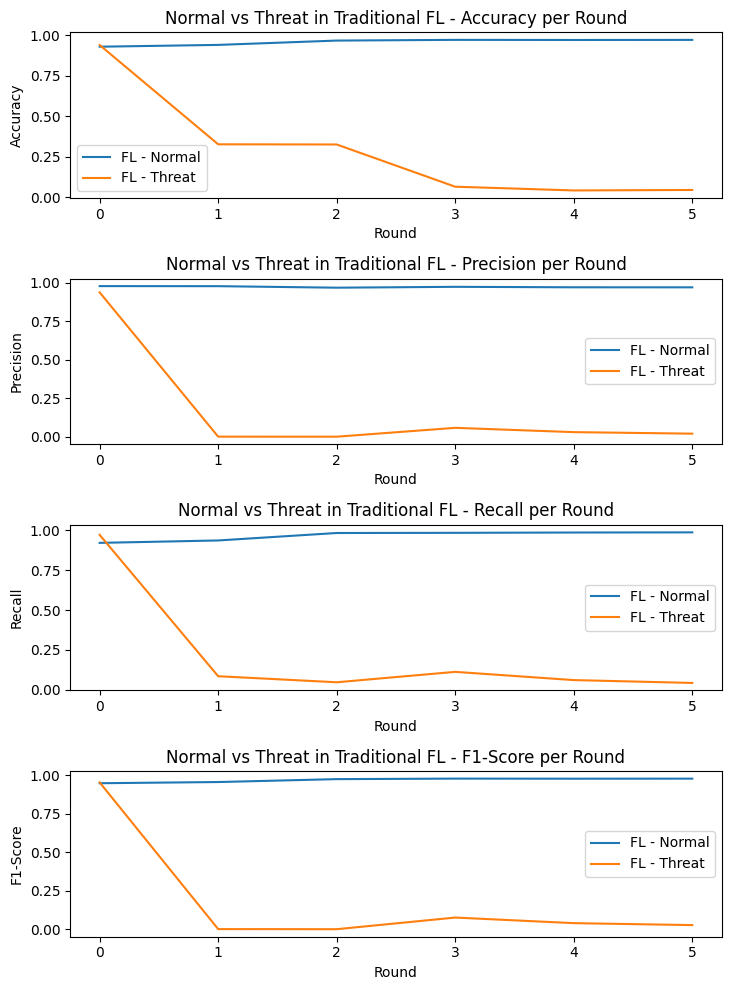

In [19]:
# Plotting results
plt.figure(figsize=(14, 10))

plt.subplot(4, 2, 1)
plt.plot(fl_global_accuracies_normal, label='FL - Normal')
plt.plot(fl_global_accuracies_threat, label='FL - Threat')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Normal vs Threat in Traditional FL - Accuracy per Round')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(fl_global_precisions_normal, label='FL - Normal')
plt.plot(fl_global_precisions_threat, label='FL - Threat')
plt.xlabel('Round')
plt.ylabel('Precision')
plt.title('Normal vs Threat in Traditional FL - Precision per Round')
plt.legend()

plt.subplot(4, 2, 5)
plt.plot(fl_global_recalls_normal, label='FL - Normal')
plt.plot(fl_global_recalls_threat, label='FL - Threat')
plt.xlabel('Round')
plt.ylabel('Recall')
plt.title('Normal vs Threat in Traditional FL - Recall per Round')
plt.legend()

plt.subplot(4, 2, 7)
plt.plot(fl_global_f1s_normal, label='FL - Normal')
plt.plot(fl_global_f1s_threat, label='FL - Threat')
plt.xlabel('Round')
plt.ylabel('F1-Score')
plt.title('Normal vs Threat in Traditional FL - F1-Score per Round')
plt.legend()

plt.tight_layout()
plt.show()

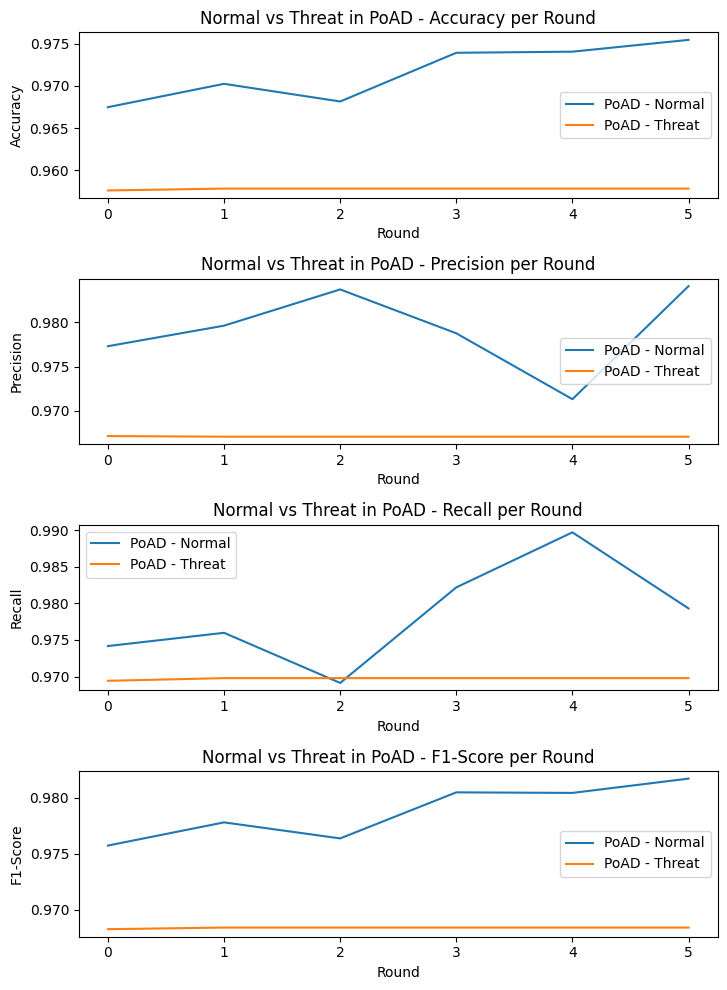

In [22]:
# Plotting results
plt.figure(figsize=(14, 10))

plt.subplot(4, 2, 2)
plt.plot(poad_global_accuracies_normal, label='PoAD - Normal')
plt.plot(poad_global_accuracies_threat, label='PoAD - Threat')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Normal vs Threat in PoAD - Accuracy per Round')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(poad_global_precisions_normal, label='PoAD - Normal')
plt.plot(poad_global_precisions_threat, label='PoAD - Threat')
plt.xlabel('Round')
plt.ylabel('Precision')
plt.title('Normal vs Threat in PoAD - Precision per Round')
plt.legend()

plt.subplot(4, 2, 6)
plt.plot(poad_global_recalls_normal, label='PoAD - Normal')
plt.plot(poad_global_recalls_threat, label='PoAD - Threat')
plt.xlabel('Round')
plt.ylabel('Recall')
plt.title('Normal vs Threat in PoAD - Recall per Round')
plt.legend()

plt.subplot(4, 2, 8)
plt.plot(poad_global_f1s_normal, label='PoAD - Normal')
plt.plot(poad_global_f1s_threat, label='PoAD - Threat')
plt.xlabel('Round')
plt.ylabel('F1-Score')
plt.title('Normal vs Threat in PoAD - F1-Score per Round')
plt.legend()

plt.tight_layout()
plt.show()